In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats import describe, skew, kurtosis
!pip install imblearn
from sklearn.decomposition import PCA
# from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import catboost as cat_
from sklearn.metrics import accuracy_score
# import lightgbm as lgb
import xgboost as xgb
import random
%matplotlib inline
import torch
import os

In [2]:
def seed_everything(seed, pytorch_init=True):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if pytorch_init is True:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

In [3]:
data = pd.read_csv("../data/generate/children_under5.csv")

In [4]:
data.head()

,V024 Region,V025 Type of place of residence,V101 Region,V102 Type of place of residence,V106 Highest educational level,V107 Highest year of education,V113 Source of drinking water,V130 Religion,V131 Ethnicity,V136 Number of household members (listed),...,M14 Number of antenatal visits during pregnancy,M49A During pregnancy took: SPfansidar for malaria,ML1 Number of times took fansidar during pregnancy,ML0 Type of mosquito bed net(s) child slept under last night,SLGA Local government area,B19 Current age of child in months (months since birth for dead children),HW1 Child's age in months,SREGION Region,SBONNY Bonny State,HML32$01 Final result of malaria from blood smear test
0,Benue,Urban,Benue,Urban,Secondary,NaN,Protected well,Catholic,Tiv,14.0,...,NaN,NaN,NaN,No net,371.0,44.0,44.0,North Central,No,Negative
1,Benue,Urban,Benue,Urban,Primary,NaN,Protected well,Catholic,Tiv,14.0,...,6.0,Yes,4.0,No net,371.0,18.0,18.0,North Central,No,Negative
2,Benue,Urban,Benue,Urban,Primary,NaN,Protected well,Catholic,Tiv,6.0,...,No antenatal visits,No,NaN,No net,371.0,5.0,5.0,North Central,No,Negative
3,Benue,Urban,Benue,Urban,Higher,NaN,Protected well,Catholic,Tiv,6.0,...,NaN,NaN,NaN,No net,371.0,43.0,43.0,North Central,No,Negative
4,Benue,Urban,Benue,Urban,Secondary,NaN,Protected well,Catholic,Tiv,9.0,...,No antenatal visits,No,NaN,No net,371.0,19.0,19.0,North Central,No,Positive


In [5]:
elements = [
    'V024     Region',
    'V025     Type of place of residence',
    'V130     Religion',
    # 'V131     Ethnicity',
    # 'V136     Number of household members (listed)',
    'V137     Number of children 5 and under in household (de jure)',
    'V149     Educational attainment',
    'V151     Sex of household head',
    # 'V155     Literacy',
    'V190     Wealth index combined',
    # 'V190A    Wealth index for urbanrural',
    'ML101    Type of mosquito bed net(s) slept under last night',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)',
    'BORD     Birth order number',
    # 'SLGA     Local government area',
    'HML32$01 Final result of malaria from blood smear test'
]

In [6]:
data = data[elements]

In [7]:
# target = 'HML32$01 Final result of malaria from blood smear test'
column_rename = {
    'V024     Region': 'V024',
    'V025     Type of place of residence': 'V025',
    'V130     Religion': 'V130',
    # 'V131     Ethnicity': 'V131',
    # 'V136     Number of household members (listed)': 'V136',
    'V137     Number of children 5 and under in household (de jure)': 'V137',
    'V149     Educational attainment': 'V149',
    'V151     Sex of household head': 'V151',
    # 'V155     Literacy': 'V155',
    'V190     Wealth index combined': 'V190',
    # 'V190A    Wealth index for urbanrural': 'V190A',
    'ML101    Type of mosquito bed net(s) slept under last night': 'ML101',
    # 'V459     Have mosquito bed net for sleeping (from household questionnaire)': 'V459',
    'BORD     Birth order number': 'BORD',
    # 'SLGA     Local government area': 'SLGA',
    'HML32$01 Final result of malaria from blood smear test': 'HML32$01'
}
target = 'HML32$01'
data.rename(columns= column_rename, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  object 
 1   V025      10465 non-null  object 
 2   V130      10465 non-null  object 
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  object 
 5   V151      10465 non-null  object 
 6   V190      10465 non-null  object 
 7   ML101     10465 non-null  object 
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  object 
dtypes: float64(2), object(8)
memory usage: 817.7+ KB


In [9]:
data.head()

,V024,V025,V130,V137,V149,V151,V190,ML101,BORD,HML32$01
0,Benue,Urban,Catholic,3.0,Incomplete secondary,Male,Richer,No net,2.0,Negative
1,Benue,Urban,Catholic,3.0,Complete primary,Male,Richer,No net,4.0,Negative
2,Benue,Urban,Catholic,1.0,Complete primary,Male,Richer,No net,2.0,Negative
3,Benue,Urban,Catholic,1.0,Higher,Male,Middle,Only treated nets,6.0,Negative
4,Benue,Urban,Catholic,2.0,Complete secondary,Male,Middle,No net,7.0,Positive


In [10]:
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10465 entries, 0 to 10464
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V024      10465 non-null  int64  
 1   V025      10465 non-null  int64  
 2   V130      10465 non-null  int64  
 3   V137      10465 non-null  float64
 4   V149      10465 non-null  int64  
 5   V151      10465 non-null  int64  
 6   V190      10465 non-null  int64  
 7   ML101     10465 non-null  int64  
 8   BORD      10465 non-null  float64
 9   HML32$01  10465 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 817.7 KB


In [12]:
data = data.fillna(data.mean())
data.isnull().sum()

V024        0
V025        0
V130        0
V137        0
V149        0
V151        0
V190        0
ML101       0
BORD        0
HML32$01    0
dtype: int64

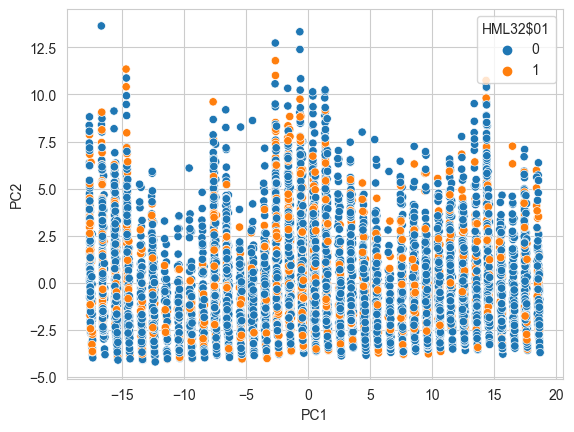

In [13]:
X = data.drop([target], axis=1)
y = data[target]

# Instantiate a PCA object and fit it to the data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the data into 2D using the PCA object
X_2d = pca.transform(X)

# Plot the transformed data
# plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [14]:
new_data =data.__deepcopy__()
Y_data = new_data.pop(target)
X_data = new_data

Class Labels Index([0, 1], dtype='int64', name='HML32$01')
Class Counts [8242 2223]
Class Percentage [78.75776398 21.24223602]


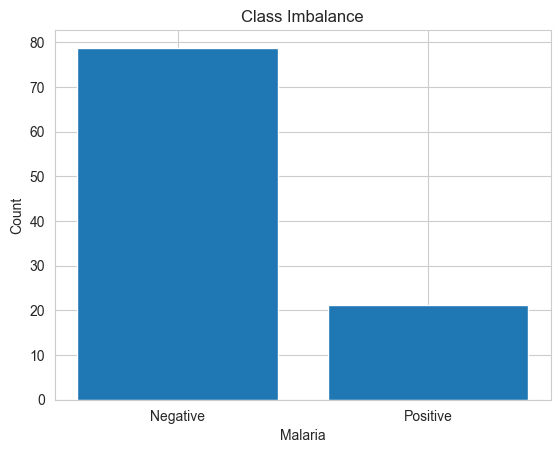

In [15]:
target_counts = Y_data.value_counts()

# Calculate the class distribution
class_labels = target_counts.index
class_counts = target_counts.values
total_samples = len(new_data)

# Calculate the percentage of each class
class_percentages = (class_counts / total_samples) * 100
print('Class Labels', class_labels)
print('Class Counts', class_counts)
print('Class Percentage', class_percentages)

# Plotting the class distribution
plt.bar(['Negative', 'Positive'], class_percentages)
plt.xlabel('Malaria')
plt.ylabel('Count')
plt.title('Class Imbalance')
plt.show()

<Axes: >

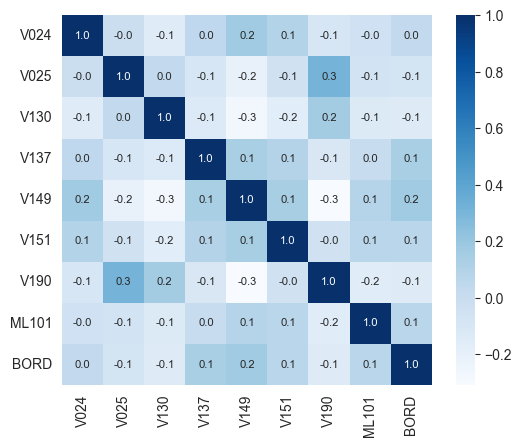

In [16]:
correlation=new_data.corr()
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8},cmap="Blues")


In [17]:
def undersampling():
    # Perform undersampling
    undersampler = RandomUnderSampler(sampling_strategy='majority')
    return undersampler.fit_resample(X_data, Y_data)


def oversampling():
    # Perform oversampling
    oversampler = RandomOverSampler(sampling_strategy='minority')
    return oversampler.fit_resample(X_data, Y_data)


def smote():
    # Perform SMOTE
    smote_sampler = SMOTE(sampling_strategy='minority')
    return smote_sampler.fit_resample(X_data, Y_data)


classifier = LogisticRegression()
results = {}
seed_everything(SEED)
for algorithm in [undersampling, oversampling, smote]:
    X, Y = algorithm()
    classifier.fit(X, Y)
    predicted_labels = classifier.predict(X_data)
    accuracy = accuracy_score(Y_data, predicted_labels)
    results[algorithm.__name__] = accuracy

# Determine the best algorithm based on the accuracy
best_algorithm = max(results, key=results.get)

# Print the results and the best algorithm
print("Sampling Algorithm Results:")
for algorithm, accuracy in results.items():
    print(f"{algorithm}: {accuracy}")
print("\nBest Algorithm:")
print(best_algorithm)

Sampling Algorithm Results:
undersampling: 0.5219302436693741
oversampling: 0.5229813664596273
smote: 0.49804108934543717

Best Algorithm:
oversampling


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
# Assume X_train and y_train are your training data
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Example threshold values to test

best_threshold = None
best_score = 0

for threshold in thresholds:
    sel = VarianceThreshold(threshold=threshold)
    X_train_selected = sel.fit_transform(X_data)
    # Assume RandomForestClassifier as your model, modify it based on your problem
    clf = RandomForestClassifier()
    scores = cross_val_score(clf, X_train_selected, Y_data, cv=5, scoring='accuracy')
    avg_score = scores.mean()
    print(f"Threshold: {threshold}, Average Cross-Validation Score: {avg_score}")
    if avg_score > best_score:
        best_score = avg_score
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Cross-Validation Score: {best_score}")

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(X_data)
sum(sel.get_support())
print(
    len([
        x for x in X_data.columns
        if x not in X_data.columns[sel.get_support()]
    ]))

importance=[x for x in X_data.columns if x not in X_data.columns[sel.get_support()]]
if len(importance) == 0 or importance == 0:
    importance = elements
    print(importance)

In [19]:
import matplotlib.patches as patches
from scipy import interp
class func():
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state

        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'log', 'rad','deci', 'svm'), 'Incorrect model_type'

    def __call__(self, plot=True):
        return self.fit(plot)

    def fit(self, plot):
        def deci_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        def svm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        def log_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict
        
        def rad_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500,
                           verbose=50, use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:, 1]
            x_train_predict = self.model.predict_proba(X_train)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:, 1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                             1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit=self.model.get_booster().best_ntree_limit)[
                              :, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit=self.model.get_booster().best_ntree_limit)[:,
                           1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose=True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration=self.model.best_iteration_)[:, 1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration=self.model.best_iteration_)[:, 1]
            return x_test_predict, x_train_predict

        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits=splits)
        
        # Plot arrows
        fig1 = plt.figure(figsize=[12, 12])
        ax1 = fig1.add_subplot(111, aspect='equal')
        # ax1.add_patch(
        #     patches.Arrow(0.45, 0.5, -0.25, 0.25, width=0.3, color='green', alpha=0.5)
        # )
        # ax1.add_patch(
        #     patches.Arrow(0.5, 0.45, 0.25, -0.25, width=0.3, color='red', alpha=0.5)
        # )

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 1
        seed_everything(SEED)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train, X_test = self.train.iloc[train_index], self.train.iloc[test_index]
            y_train, y_test = self.label.iloc[train_index], self.label.iloc[test_index]

            print(f"================================Fold{fold_count + 1}====================================")
            if self.model_type == 'catboost':
                x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost':
                x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rad':
                x_test_predict, x_train_predict = rad_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'log':
                x_test_predict, x_train_predict = log_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm':
                x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'deci':
                x_test_predict, x_train_predict = deci_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'svm':
                x_test_predict, x_train_predict = svm_fit(X_train, X_test, y_train, y_test)
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_train, x_train_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, x_test_predict)
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i = i + 1
        fig1 = plt.figure(figsize=[12, 12])
        ax1 = fig1.add_subplot(111, aspect='equal')    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right")
        # plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
        # plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
        plt.show()
        
        if plot and self.model_type != 'log' and self.model_type != 'svm':
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_, self.train.columns)),
                                    columns=['Value', 'Feature'])
            plt.figure(figsize=(30, 25))
            # sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.barh(feat_imp['Feature'], feat_imp['Value'])
            plt.xlabel('Feature Importance Score',fontsize=40)
            plt.ylabel('Features',fontsize=40)
            plt.title('Feature Importance',fontsize=40)
            plt.tick_params(axis='both', labelsize=40)
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p / splits, self.model, mean_fpr, mean_tpr, mean_auc

In [20]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import layers
# import keras_tuner

In [22]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
xgboost = xgb.XGBClassifier(objectsve='binary:logistic',
                            eta=0.99,
                            max_depth=6,
                            n_estimators=5000,
                            reg_lambda=500,
                            scoring='f1',
                            sub_sample=0.8,
                            colsample_bytree=0.8)
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='TotalF1', reg_lambda=370)
clf_rad = RandomForestClassifier()
tree_clf = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=2)
svm = SVC(kernel='sigmoid', C=1, probability=True)
def run_predictions(X_train, y_train, X_test):
    # classifier with cross validation and feature selection
    func_ = func(X_train, y_train, X_test, classifier, 'log', 1000)
    val_p, test_p, model,mean_fpr, mean_tpr, mean_auc  = func_()
    func_ = func(X_train, y_train, X_test, catboost, 'catboost', 1000)
    val_p1, test_p1, model1, mean_fpr1, mean_tpr1, mean_auc1 = func_()
    func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
    val_p2, test_p2, model2, mean_fpr2, mean_tpr2, mean_auc2 = func_()
    func_ = func(X_train, y_train, X_test, clf_rad, 'rad', 1000)
    val_p3, test_p3, model3, mean_fpr3, mean_tpr3, mean_auc3 = func_()
    func_ = func(X_train, y_train, X_test, tree_clf, 'deci', 1000)
    val_p4, test_p4, model4, mean_fpr4, mean_tpr4, mean_auc4 = func_()
    func_ = func(X_train, y_train, X_test, svm, 'svm', 1000)
    val_p5, test_p5, model5, mean_fpr5, mean_tpr5, mean_auc5 = func_()
    fig1 = plt.figure(figsize=[12, 12])
    ax1 = fig1.add_subplot(111, aspect='equal')    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')
    plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC for Logistic Regression (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
    plt.plot(mean_fpr1, mean_tpr1, color='red', label=r'Mean ROC for Catboost (AUC = %0.2f )' % (mean_auc1), lw=2, alpha=1)
    plt.plot(mean_fpr3, mean_tpr3, color='brown', label=r'Mean ROC for RandomForest (AUC = %0.2f )' % (mean_auc3), lw=2, alpha=1)
    plt.plot(mean_fpr4, mean_tpr4, color='orange', label=r'Mean ROC for Decision tree (AUC = %0.2f )' % (mean_auc4), lw=2, alpha=1)
    plt.plot(mean_fpr5, mean_tpr5, color='purple', label=r'Mean ROC for Support Vector Machine (AUC = %0.2f )' % (mean_auc5), lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
        # plt.text(0.32, 0.7, 'More accurate area', fontsize=12)
        # plt.text(0.63, 0.4, 'Less accurate area', fontsize=12)
    plt.show()
    return model, model1, model2, model3,model4, model5

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix,auc,roc_curve


def evaluate_model(y_true, y_pred, average='binary'):
    """
    Function to evaluate a machine learning model's performance using common evaluation metrics and the classification report.

    Parameters:
        y_true (array-like): The true labels of the data.
        y_pred (array-like): The predicted labels of the data.
        average (str, optional): The type of averaging to use for multi-class classification.
                                 Can be 'binary', 'micro', 'macro', or 'weighted'. Default is 'binary'.
                                 Ignored for binary classification problems.

    Returns:
        dict: A dictionary containing the evaluation metrics and the centered classification report.
    """

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('Unique instance ', np.unique(y_true, return_counts=True), np.unique(y_pred, return_counts=True))
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # print('Confusion matrix', tn, fp, fn, tp)
    # print(confusion_matrix(y_true, y_pred))
    # precision = tp/(tp+fp)
    # recall = tp/(tp+fn)
    # f1 = 2*precision*recall/(precision+recall)
    # # Calculate classification report
    aa  = classification_report(y_true, y_pred, output_dict=True)
    print(aa)
    report = classification_report(y_true, y_pred)
    print('Accuracy', accuracy)
    print('Precision', precision)
    print('Recall', recall)
    print('F1 Score', f1)
    print('Classification Report')
    print(report)

    # Create dictionary of evaluation metrics and centered classification report
    metrics = {'accuracy': accuracy,
               'precision': precision,
               'recall': recall,
               'f1': f1}
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    class_names = ['Class 0', 'Class 1']
    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    print('Metrics for the  Evaluation is',metrics)
    return metrics

In [ ]:
def eveluate_model_results(model1,model2, model, model3, model4, model5, nn_result, y_test, X_test):
    catboost_result = evaluate_model(y_test, model1.predict(X_test))
    xgboost_result = evaluate_model(y_test, model2.predict(X_test))
    logistic_regression_result = evaluate_model(y_test, model.predict(X_test))
    rad_regression_result = evaluate_model(y_test, model3.predict(X_test))
    deci_result = evaluate_model(y_test, model4.predict(X_test))
    svm_result = evaluate_model(y_test, model5.predict(X_test))
    print(
        {
          "catboost_result": catboost_result,
            "xgb":xgboost_result,
            "log":logistic_regression_result,
            "neural": nn_result,
            "radom_forest": rad_regression_result,
            "svm": svm_result,
            "decision_tree": deci_result
        }
    )
    accuracy_list = [catboost_result['accuracy'], xgboost_result['accuracy'], logistic_regression_result['accuracy'], rad_regression_result['accuracy'],nn_result['accuracy'], deci_result['accuracy'], svm_result['accuracy']]
    precision_list = [catboost_result['precision'], xgboost_result['precision'], logistic_regression_result['precision'],rad_regression_result['accuracy'], nn_result['precision'], deci_result['precision'], svm_result['precision']]
    recall_list = [catboost_result['recall'], xgboost_result['recall'], logistic_regression_result['recall'],rad_regression_result['accuracy'], nn_result['recall'], deci_result['recall'], svm_result['recall']]
    f1_list = [catboost_result['f1'], xgboost_result['f1'], logistic_regression_result['f1'], rad_regression_result['accuracy'], nn_result['f1'], deci_result['f1'], svm_result['f1']]
    
    # Calculate percentages for accuracy list
    total_accuracy = sum(accuracy_list)
    accuracy_percentages = [round((accuracy / total_accuracy) * 100, 2) for accuracy in accuracy_list]
    
    # Calculate percentages for precision list
    total_precision = sum(precision_list)
    precision_percentages = [round((precision / total_precision) * 100, 2) for precision in precision_list]
    
    # Calculate percentages for recall list
    total_recall = sum(recall_list)
    recall_percentages = [round((recall / total_recall) * 100, 2) for recall in recall_list]
    
    # Calculate percentages for f1 list
    total_f1 = sum(f1_list)
    f1_percentages = [round((f1 / total_f1) * 100, 2) for f1 in f1_list]
    
    # Set colors for the bars
    colors = ['#FFC107', '#FF5722', '#4CAF50']
    
    # Plot for accuracy list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest', 'Neural Network', 'Decision Tree', 'SVM'], accuracy_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of different models')
    
    # Add percentage labels to the bars
    for i, accuracy in enumerate(accuracy_list):
        plt.text(i, accuracy + 0.5, f"{accuracy_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for precision list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network','Decision Tree', 'SVM'], precision_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.title('Precision of different models')
    
    # Add percentage labels to the bars
    for i, precision in enumerate(precision_list):
        plt.text(i, precision + 0.01, f"{precision_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for recall list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network', 'Decision Tree', 'SVM'], recall_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('Recall')
    plt.title('Recall of different models')
    
    # Add percentage labels to the bars
    for i, recall in enumerate(recall_list):
        plt.text(i, recall + 0.01, f"{recall_percentages[i]}%", ha='center')
    
    plt.show()
    
    # Plot for f1 list with percentages
    plt.figure(figsize=(12, 6))
    plt.bar(['Catboost', 'XGBoost', 'Logistic Regression','Random Forest','Neural Network', 'Decision Tree', 'SVM'], f1_list, color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('F1 Score of different models')
    
    # Add percentage labels to the bars
    for i, f1 in enumerate(f1_list):
        plt.text(i, f1 + 0.01, f"{f1_percentages[i]}%", ha='center')
    
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42,stratify=Y_data)

In [ ]:
func_ = func(X_train, y_train, X_test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # one hot representation
# _y_train = to_categorical(y_train)
# # _y_test = to_categorical(y_test)
# 
# # Normalization
# minmaxscaler = MinMaxScaler(feature_range = (0,1))
# X_train = minmaxscaler.fit_transform(X_train)
# X_test = minmaxscaler.transform(X_test)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def train_neural(X_train, y_train, X_test, y_test):
 
    # one hot representation
    y_train = to_categorical(y_train)
    # _y_test = to_categorical(y_test)
    
    # Normalization
    minmaxscaler = MinMaxScaler(feature_range = (0,1))
    X_train = minmaxscaler.fit_transform(X_train)
    X_test = minmaxscaler.transform(X_test)

    network = Sequential()
    network.add(Dense(50, activation='relu', input_dim=X_train.shape[-1]))
    network.add(Dropout(0.2))
    network.add(Dense(25, activation='relu'))
    network.add(Dense(7, activation='relu'))
    network.add(Dense(2, activation='softmax'))  # Changed activation to 'softmax'
    network.compile(optimizer='adam',
                    loss='categorical_crossentropy',  # Changed loss function
                    metrics=['accuracy'])
    network.fit(X_train, y_train, epochs=3, batch_size=128, verbose=0)
    ppred = network.predict(X_test)
    predicted_labels = np.argmax(ppred, axis=1)
    print(y_test)
    nn_result = evaluate_model(y_test,predicted_labels)
    return nn_result

# Assuming y_train and y_test are integer labels (e.g., 0, 1)
# aa = train_neural(X_train, y_train, X_test, y_test)
# scores2 = aa.evaluate(X_test, y_test, verbose=2)
# rounded_predictions = aa.predict(X_test)

In [ ]:
# Results without cross validation and without sampling
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_out_cross_classifier = classifier.fit(X_train, y_train)
with_out_cross_catboost = catboost.fit(X_train, y_train)
with_out_cross_xgboost = xgboost.fit(X_train, y_train)
with_out_cross_rad = clf_rad.fit(X_train, y_train)
with_out_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
with_out_cross_deci = tree_clf.fit(X_train, y_train)
with_out_cross_svm = svm.fit(X_train, y_train)
eveluate_model_results(with_out_cross_catboost,with_out_cross_xgboost, with_out_cross_classifier,with_out_cross_rad, with_out_cross_deci, with_out_cross_svm,with_out_cross_neural_result, y_test, X_test)

In [ ]:
# a a=a as 

In [ ]:
# # Results with cross validation and without sampling
# with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_out_cross_rad = run_predictions(X_train,y_train, X_test)
# with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
# eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_neural_result, y_test, X_test)

In [ ]:
# Results  cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, stratify=Y_data)
with_cross_classifier,with_cross_catboost,with_cross_xgboost, with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_out_cross_rad, with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)

In [ ]:
# Results with cross validation and oversamplying
_X, _Y = oversampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad,  with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)

In [ ]:
_X, _Y = smote()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad,with_cross_deci, with_cross_svm, with_cross_neural_result, y_test, X_test)

In [ ]:
_X, _Y = undersampling()
X_train, X_test, y_train, y_test = train_test_split(_X, _Y, test_size=0.2, random_state=42, stratify=_Y)
with_cross_classifier,with_cross_catboost,with_cross_xgboost,with_cross_rad, with_cross_deci, with_cross_svm = run_predictions(X_train,y_train, X_test)
with_cross_neural_result = train_neural(X_train,y_train,X_test, y_test)
eveluate_model_results(with_cross_catboost,with_cross_xgboost, with_cross_classifier, with_cross_rad, with_cross_deci, with_cross_svm,with_cross_neural_result, y_test, X_test)